<center>
<img src="../../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 10
## <center> Прогнозирование задержек вылетов

Ваша задача – побить как минимум 2 бенчмарка в [соревновании](https://www.kaggle.com/c/flight-delays-spring-2018) на Kaggle Inclass. Подробных инструкций не будет, будет только тезисно описано, как получен второй – с помощью Xgboost. Надеюсь, на данном этапе курса вам достаточно бросить полтора взгляда на данные, чтоб понять, что это тот тип задачи, в которой затащит градиентный бустинг. Скорее всего Xgboost, но тут у нас еще немало категориальных признаков...

<img src='../../../img/xgboost_meme.jpg' width=40% />

In [1]:
import os
os.environ['JOBLIB_TEMP_FOLDER']="/tmp"

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [3]:
train = pd.read_csv('../../../data/flight_delays_train.csv')
test = pd.read_csv('../../../data/flight_delays_test.csv')

In [4]:
len(train), len(test)

(100000, 100000)

In [5]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [6]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [7]:
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

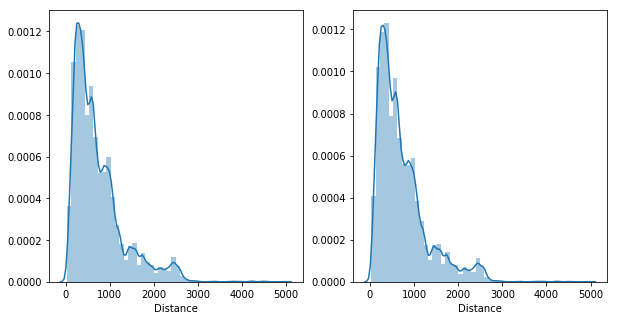

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.distplot(train["Distance"])
plt.subplot(122)
sns.distplot(test["Distance"])

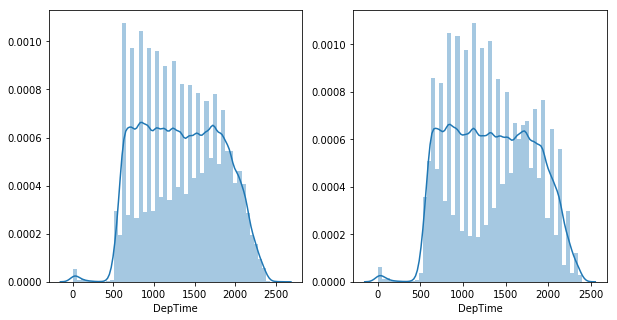

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
sns.distplot(train["DepTime"])
plt.subplot(122)
sns.distplot(test["DepTime"])

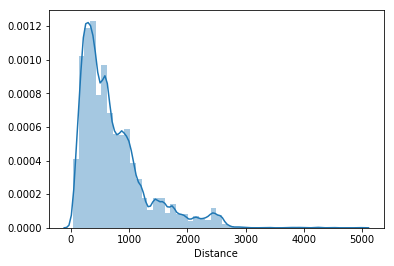

In [10]:
sns.distplot(test["Distance"])

In [11]:
unique_carriers = np.concatenate([train['UniqueCarrier'].unique(), test['UniqueCarrier'].unique()])
len(unique_carriers)

42

In [12]:
set(train['Origin'].unique()) - set(test['Origin'].unique())

{'CDC', 'HKY', 'HVN', 'ISO', 'PIE', 'VCT', 'VIS'}

In [13]:
set(train['UniqueCarrier'].unique()) - set(test['UniqueCarrier'].unique())

{'DH', 'HP', 'TZ'}

In [14]:
train[train['dep_delayed_15min'] == "Y"]['UniqueCarrier'].value_counts()

WN    3219
AA    1770
MQ    1448
DL    1373
UA    1322
OO    1277
US    1085
EV    1082
NW    1075
XE    1026
OH     808
CO     788
FL     736
AS     541
YV     478
B6     393
HP     196
F9     156
DH     156
TZ      64
HA      33
AQ      18
Name: UniqueCarrier, dtype: int64

In [15]:
train[train['dep_delayed_15min'] == "Y"]['Origin'].value_counts()

ATL    1506
ORD    1254
DFW     902
DEN     575
LAX     552
LAS     546
EWR     538
IAH     492
PHX     491
DTW     401
PHL     388
MSP     362
CVG     360
SFO     360
LGA     350
MDW     343
BOS     332
JFK     332
MCO     326
SEA     322
SLC     304
CLT     288
IAD     284
BWI     282
SAN     213
OAK     211
MIA     207
TPA     202
FLL     192
DCA     190
       ... 
YAK       2
ITO       2
DBQ       2
TYR       2
LSE       2
FLO       1
BRO       1
GTF       1
GTR       1
GGG       1
SCE       1
ISO       1
CDC       1
GST       1
BGM       1
SJT       1
ERI       1
ADK       1
CWA       1
HTS       1
BPT       1
ACY       1
ACK       1
CDV       1
BTM       1
HLN       1
EKO       1
TEX       1
MQT       1
BLI       1
Name: Origin, Length: 269, dtype: int64

In [10]:
train.loc[:, 'target'] = train['dep_delayed_15min'].map({'Y': 1, 'N': 0})

In [9]:

def add_cat_features(df):    
    df.loc[:, 'dep_hour'] = df['DepTime'].apply(lambda x: int(x//100))
    df.loc[:, "origin_carrier"] = df["Origin"] + "_" + df["UniqueCarrier"]
    df.loc[:, "dest_carrier"] = df["Dest"] + "_" + df["UniqueCarrier"]
    df.loc[:, "dep_hour_carrier"] = df["dep_hour"].astype(str) + "_" + df["UniqueCarrier"]
    df.loc[:, "dep_hour_origin"] = df["dep_hour"].astype(str) + "_" + df["Origin"]
    df.loc[:, "dep_hour_dest"] = df["dep_hour"].astype(str) + "_" + df["Dest"]
    df.loc[:, "dep_hour_origin_carrier"] = df["dep_hour"].astype(str) + "_" + df["Origin"] + "_" + df["UniqueCarrier"]
    df.loc[:, "week_dep_hour"] = df["DayOfWeek"].astype(str) + "_" + df["dep_hour"].astype(str)
    # df.loc[:, "route"] = df["Origin"] + "_" + df["Dest"]


add_cat_features(train)
add_cat_features(test)

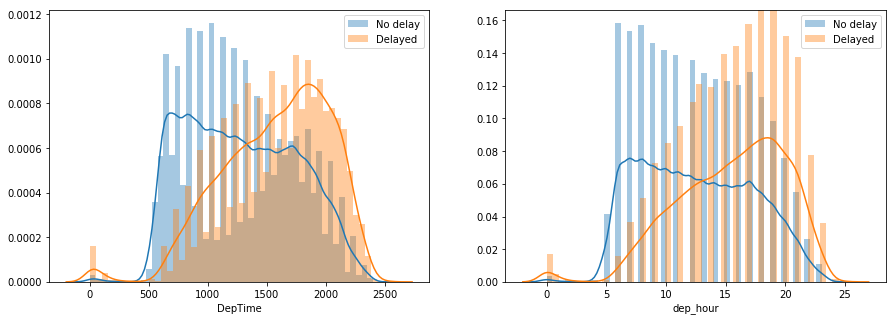

In [18]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.distplot(train[train["target"] == 0]["DepTime"], label="No delay")
sns.distplot(train[train["target"] == 1]["DepTime"], label="Delayed")
plt.legend()
plt.subplot(122)
sns.distplot(train[train["target"] == 0]["dep_hour"], label="No delay")
sns.distplot(train[train["target"] == 1]["dep_hour"], label="Delayed")
plt.legend()

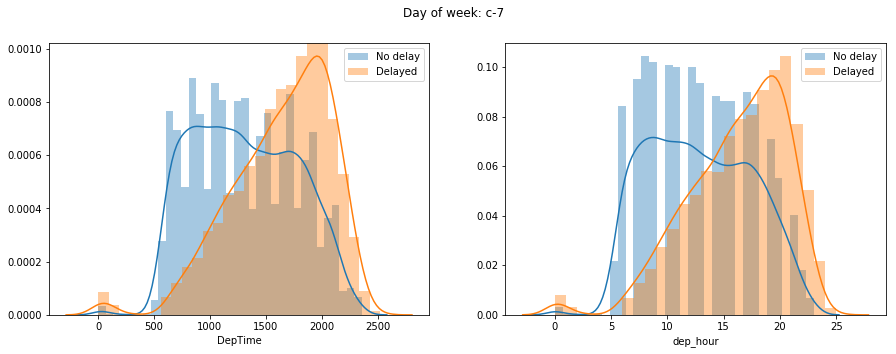

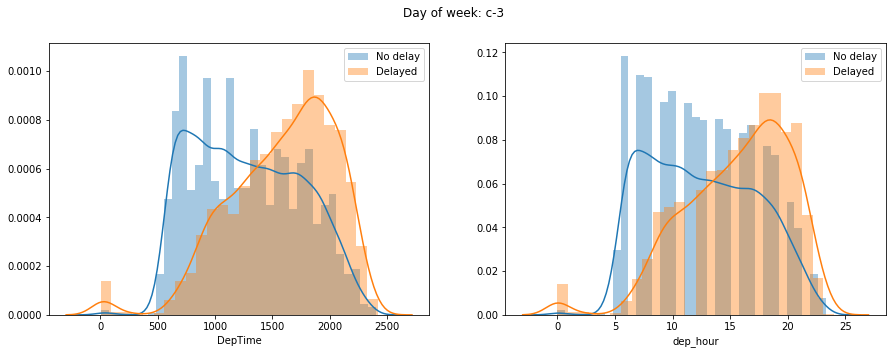

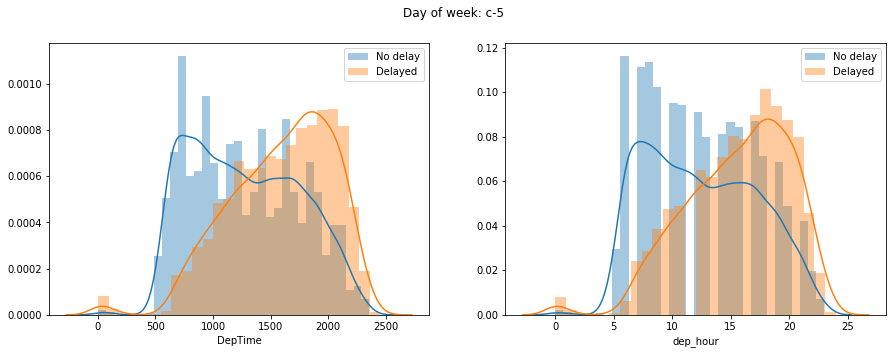

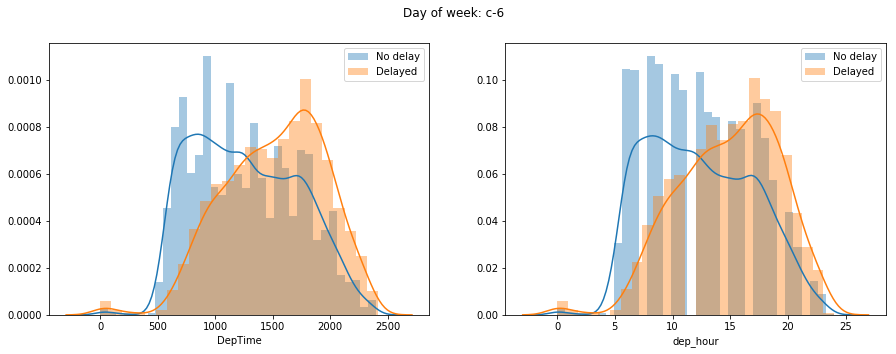

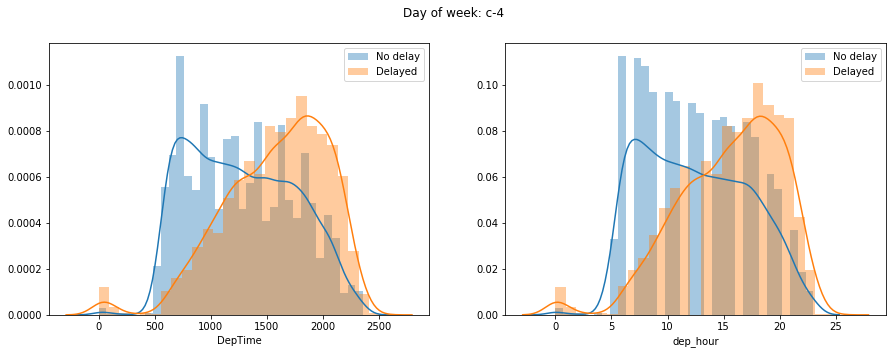

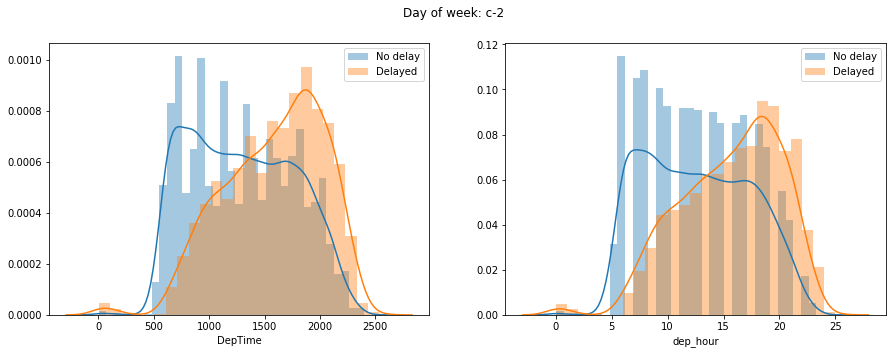

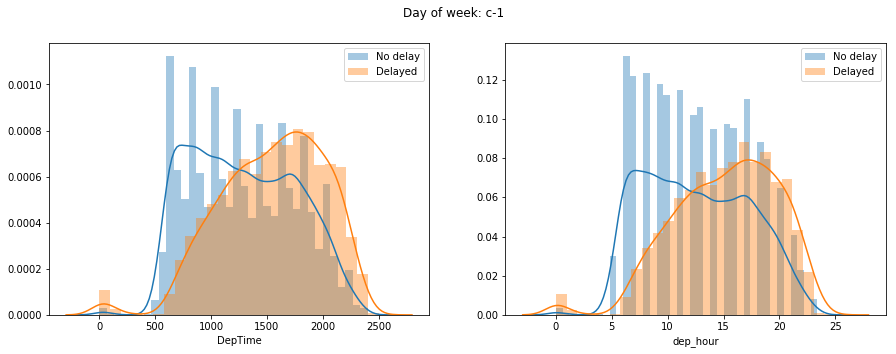

In [38]:
for w in train["DayOfWeek"].unique():
    mask = train["DayOfWeek"] == w
    plt.figure(figsize=(15, 5))
    plt.suptitle("Day of week: {}".format(w))
    plt.subplot(121)
    sns.distplot(train[mask & (train["target"] == 0)]["DepTime"], label="No delay")
    sns.distplot(train[mask & (train["target"] == 1)]["DepTime"], label="Delayed")
    plt.legend()
    plt.subplot(122)
    sns.distplot(train[mask & (train["target"] == 0)]["dep_hour"], label="No delay")
    sns.distplot(train[mask & (train["target"] == 1)]["dep_hour"], label="Delayed")
    plt.legend()

In [17]:
columns = train.columns.values.tolist()
columns.remove('dep_delayed_15min')
columns.remove('target')
len(columns)

16

In [18]:
import catboost as cat

In [19]:
X = train[columns].values 
y = train['target'].values
X_test = test[columns].values
cat_features_idx = np.where(train[columns].dtypes == 'object')[0].tolist()
cat_features_idx

[0, 1, 2, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

holdout = StratifiedShuffleSplit(test_size=0.4, random_state=2018)

for train_index, test_index in holdout.split(X, y):
    break

In [21]:
X_train = X[train_index]
y_train = y[train_index]
X_val = X[test_index]
y_val = y[test_index]

dtrain = cat.Pool(X_train, label=y_train, cat_features=cat_features_idx)
dval = cat.Pool(X_val, label=y_val, cat_features=cat_features_idx)

params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.02,
    'l2_leaf_reg': 4,
    'depth': 5,
    'od_type': 'Iter',
    'od_wait': 50,
}

cvresults = cat.cv(dtrain, params=params, num_boost_round=4000, stratified=True, nfold=5, verbose_eval=50)

0:	learn: 0.6489300	test: 0.6482600	best: 0.6482600 (0)	total: 188ms	remaining: 12m 30s
50:	learn: 0.7015914	test: 0.7043270	best: 0.7043270 (50)	total: 6.44s	remaining: 8m 18s
100:	learn: 0.7241280	test: 0.7253461	best: 0.7253461 (100)	total: 13.3s	remaining: 8m 34s
150:	learn: 0.7367383	test: 0.7387038	best: 0.7387038 (150)	total: 20.7s	remaining: 8m 46s
200:	learn: 0.7433075	test: 0.7462690	best: 0.7462690 (200)	total: 28s	remaining: 8m 49s
250:	learn: 0.7479493	test: 0.7511593	best: 0.7511593 (250)	total: 35.5s	remaining: 8m 49s
300:	learn: 0.7513855	test: 0.7540618	best: 0.7540618 (300)	total: 42.8s	remaining: 8m 45s
350:	learn: 0.7540950	test: 0.7564016	best: 0.7564016 (350)	total: 49.8s	remaining: 8m 37s
400:	learn: 0.7562237	test: 0.7581245	best: 0.7581245 (400)	total: 56.8s	remaining: 8m 29s
450:	learn: 0.7579689	test: 0.7593657	best: 0.7593657 (450)	total: 1m 3s	remaining: 8m 20s
500:	learn: 0.7598039	test: 0.7606235	best: 0.7606235 (500)	total: 1m 10s	remaining: 8m 13s
550:	

In [22]:
cvresults['test-AUC-mean'].argmax(), cvresults['test-AUC-mean'].max()

(3974, 0.7721081773404662)

In [23]:
catmodel = cat.train(dtrain, params=params, num_boost_round=cvresults['test-AUC-mean'].argmax(), verbose=100)

0:	learn: 0.6896897	total: 42.1ms	remaining: 2m 47s
100:	learn: 0.7344541	total: 3.91s	remaining: 2m 29s
200:	learn: 0.7537376	total: 8.36s	remaining: 2m 36s
300:	learn: 0.7614773	total: 13s	remaining: 2m 39s
400:	learn: 0.7661158	total: 17.7s	remaining: 2m 37s
500:	learn: 0.7693054	total: 22.3s	remaining: 2m 34s
600:	learn: 0.7718559	total: 26.9s	remaining: 2m 30s
700:	learn: 0.7740788	total: 31.4s	remaining: 2m 26s
800:	learn: 0.7757644	total: 36s	remaining: 2m 22s
900:	learn: 0.7771963	total: 40.4s	remaining: 2m 17s
1000:	learn: 0.7786906	total: 45s	remaining: 2m 13s
1100:	learn: 0.7801613	total: 49.7s	remaining: 2m 9s
1200:	learn: 0.7815096	total: 54.3s	remaining: 2m 5s
1300:	learn: 0.7827885	total: 59s	remaining: 2m 1s
1400:	learn: 0.7841020	total: 1m 3s	remaining: 1m 56s
1500:	learn: 0.7853501	total: 1m 8s	remaining: 1m 52s
1600:	learn: 0.7866398	total: 1m 12s	remaining: 1m 48s
1700:	learn: 0.7879135	total: 1m 17s	remaining: 1m 43s
1800:	learn: 0.7891259	total: 1m 22s	remaining: 

In [24]:
cat_val_pred = catmodel.predict(dval, prediction_type='Probability')[:, 1]
roc_auc_score(y_val, cat_val_pred)

0.7781924586615094

In [25]:
columns

['Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'UniqueCarrier',
 'Origin',
 'Dest',
 'Distance',
 'dep_hour',
 'origin_carrier',
 'dest_carrier',
 'dep_hour_carrier',
 'dep_hour_origin',
 'dep_hour_dest',
 'dep_hour_origin_carrier',
 'week_dep_hour']

In [26]:
feat_importance = catmodel.get_feature_importance(dval)
[(n, f) for n, f in zip(columns, feat_importance)]

[('Month', 5.813297142960669),
 ('DayofMonth', 4.040593874058258),
 ('DayOfWeek', 3.436107606799213),
 ('DepTime', 20.9426405210998),
 ('UniqueCarrier', 3.98741210718419),
 ('Origin', 2.9335806552895947),
 ('Dest', 5.37832465072686),
 ('Distance', 4.961424715475005),
 ('dep_hour', 2.629825779479667),
 ('origin_carrier', 6.636815356433767),
 ('dest_carrier', 5.128765902550995),
 ('dep_hour_carrier', 7.554865275393359),
 ('dep_hour_origin', 8.723494061975686),
 ('dep_hour_dest', 7.025837276566685),
 ('dep_hour_origin_carrier', 5.239266164216139),
 ('week_dep_hour', 5.567748909790102)]

Обучение на всей выборке

In [27]:
dtrain = cat.Pool(X, label=y, cat_features=cat_features_idx)
catmodel = cat.train(dtrain, params=params, num_boost_round=cvresults['test-AUC-mean'].argmax(), verbose=100)

0:	learn: 0.6863520	total: 90.1ms	remaining: 5m 58s
100:	learn: 0.7501983	total: 6.38s	remaining: 4m 4s
200:	learn: 0.7668084	total: 13.9s	remaining: 4m 20s
300:	learn: 0.7737055	total: 22s	remaining: 4m 27s
400:	learn: 0.7774355	total: 30s	remaining: 4m 27s
500:	learn: 0.7802027	total: 38.1s	remaining: 4m 23s
600:	learn: 0.7822752	total: 46.2s	remaining: 4m 19s
700:	learn: 0.7841222	total: 54.4s	remaining: 4m 14s
800:	learn: 0.7858254	total: 1m 2s	remaining: 4m 7s
900:	learn: 0.7870111	total: 1m 10s	remaining: 4m
1000:	learn: 0.7882532	total: 1m 18s	remaining: 3m 53s
1100:	learn: 0.7892905	total: 1m 26s	remaining: 3m 46s
1200:	learn: 0.7902556	total: 1m 35s	remaining: 3m 39s
1300:	learn: 0.7912064	total: 1m 43s	remaining: 3m 32s
1400:	learn: 0.7920226	total: 1m 51s	remaining: 3m 24s
1500:	learn: 0.7928599	total: 1m 59s	remaining: 3m 16s
1600:	learn: 0.7936276	total: 2m 7s	remaining: 3m 9s
1700:	learn: 0.7944758	total: 2m 15s	remaining: 3m 1s
1800:	learn: 0.7952655	total: 2m 23s	remain

In [28]:
dtest = cat.Pool(X_test, cat_features=cat_features_idx)

cat_test_pred = catmodel.predict(dtest, prediction_type='Probability')[:, 1]
pd.Series(cat_test_pred, name='dep_delayed_15min').to_csv('catboost_16Boverfeat.csv', index_label='id', header=True)

In [29]:
!head -5 catboost_16Boverfeat.csv

id,dep_delayed_15min
0,0.015491777966478614
1,0.037402216123723395
2,0.021614627340598686
3,0.35287003299828856


In [30]:
!head -5 catboost_12overfeat.csv

id,dep_delayed_15min
0,0.014406738220320278
1,0.04316495906299868
2,0.02456703711886538
3,0.3574633491736791
